In [8]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input,Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [9]:
msft = yf.Ticker("NVDA")

# get all stock info
msft.info

# get historical market data
hist = msft.history(period="5y")

In [10]:
hist.index = pd.to_datetime(hist.index)
hist.index = hist.index.strftime('%Y-%m-%d')

In [11]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-06-28,4.101325,4.110522,4.035455,4.082185,397668000,0.0,0.0
2019-07-01,4.289488,4.323790,4.092873,4.130407,709756000,0.0,0.0
2019-07-02,4.113752,4.134881,4.019298,4.032472,400228000,0.0,0.0
2019-07-03,4.055836,4.061554,3.985493,4.045397,246636000,0.0,0.0
2019-07-05,3.986984,3.991459,3.919374,3.982759,396552000,0.0,0.0


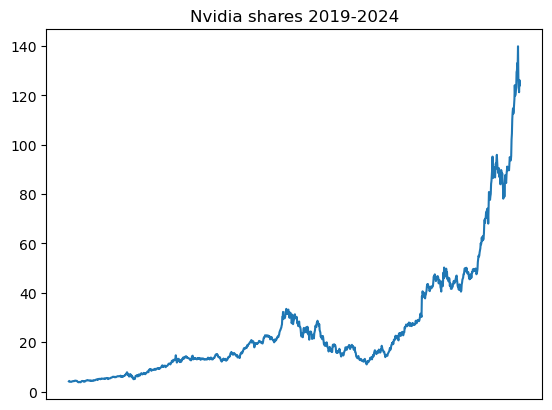

In [12]:
plt.plot(hist['Open'])
plt.xticks([])
plt.title("Nvidia shares 2019-2024")
plt.savefig("./images/nvidia_shares_201")
plt.show()

In [13]:
set_entrenamiento = hist[:'2022'].iloc[:,1:2]
set_validacion = hist['2022':].iloc[:,1:2]

In [14]:
minmax = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = minmax.fit_transform(set_entrenamiento)

In [15]:
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
  X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
  Y_train.append(set_entrenamiento_escalado[i,0])

X_train,Y_train = np.array(X_train),np.array(Y_train)

In [16]:
x_test = set_validacion.values
x_test = minmax.transform(x_test)

/home/nicolaszf/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [17]:
X_test = []
Y_test = []

for i in range(time_step,len(x_test)):
  Y_test.append(x_test[i,0])
  X_test.append(x_test[i-time_step:i,0])

X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [35]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 100

## Training test

In [36]:
modelo = Sequential()
modelo.add(Input(shape=dim_entrada))
modelo.add(LSTM(units=na, return_sequences=True))
modelo.add(Dropout(0.2))
# modelo.add(LSTM(units=na, return_sequences=True))
# modelo.add(Dropout(0.3))
modelo.add(LSTM(units=na))
modelo.add(Dropout(0.2))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop',loss='mse')

In [20]:
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
modelo.fit(X_train,Y_train,epochs=40,batch_size=32,validation_data=(X_test,Y_test),verbose=0)

In [22]:
prediccion_train = modelo.predict(X_train)
prediccion_train = minmax.inverse_transform(prediccion_train)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


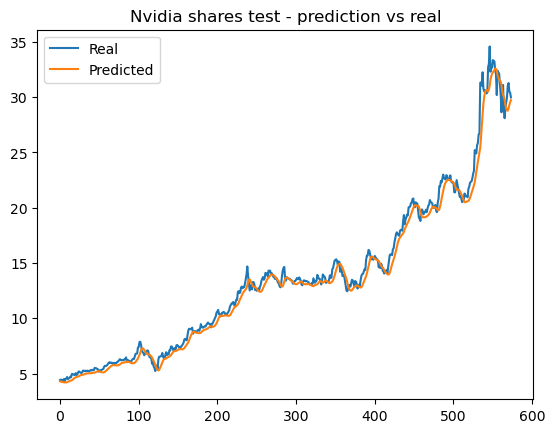

In [23]:
plt.plot(minmax.inverse_transform(np.array(Y_train).reshape(-1,1)),label='Real')
plt.plot(prediccion_train,label='Predicted')
plt.legend()
plt.title('Nvidia shares test - prediction vs real')
plt.savefig("images/nvidia_predicion_train.png")
plt.show()

## Validation test

In [24]:
modelo = Sequential()
modelo.add(Input(shape=dim_entrada))
modelo.add(LSTM(units=na, return_sequences=True))
modelo.add(Dropout(0.2))
# modelo.add(LSTM(units=na, return_sequences=True))
# modelo.add(Dropout(0.3))
modelo.add(LSTM(units=na))
modelo.add(Dropout(0.2))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop',loss='mse')

In [25]:
modelo.fit(X_train,Y_train,epochs=40,batch_size=32,validation_data=(X_test,Y_test),verbose=0)

In [26]:
prediccion_test = modelo.predict(X_test)
prediccion_test = minmax.inverse_transform(prediccion_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


In [27]:
ultimos_60_dias = x_test[-time_step:]
predicciones_futuras = []

for _ in range(10):
    input_seq = ultimos_60_dias.reshape((1, time_step, 1))
    prediccion = modelo.predict(input_seq)
    predicciones_futuras.append(prediccion[0, 0])
    ultimos_60_dias = np.append(ultimos_60_dias[1:], prediccion)

predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras = minmax.inverse_transform(predicciones_futuras)

print("Predicciones para los próximos 10 días:", predicciones_futuras)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicciones para los próximos 10 días: [[105.13725 ]
 [103.32186 ]
 [100.93513 ]
 [ 98.25062 ]
 [ 95.442444]
 [ 92.6166  ]
 [ 89.83575 ]
 [ 87.13545 ]
 [ 84.5346  ]
 [ 82.04212 ]]


In [28]:
prediccion_test = np.append(prediccion_test[0:],predicciones_futuras[0:]).reshape(-1,1)

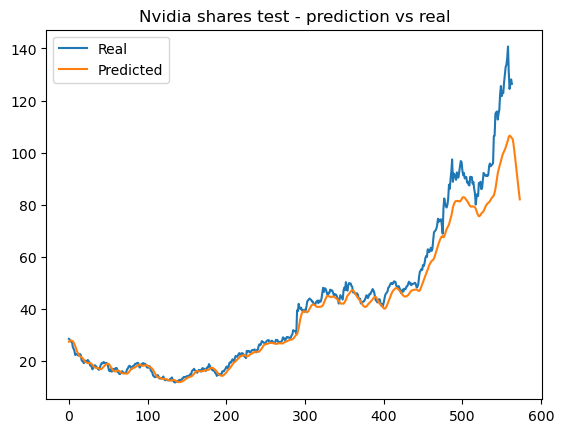

In [29]:
import matplotlib.pyplot as plt

plt.plot(minmax.inverse_transform(np.array(Y_test).reshape(-1,1)),label='Real')
plt.plot(prediccion_test,label='Predicted')
plt.legend()
plt.title("Nvidia shares test - prediction vs real")
plt.savefig("images/nvidia_predicion_test.png")
plt.show()

## Accuracy

In [37]:
accuracy = modelo.fit(X_train,Y_train,epochs=40,batch_size=32,verbose=0,validation_split=0.2)

Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 0.0215 - val_loss: 0.0055
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0033 - val_loss: 0.0128
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0014 - val_loss: 0.0172
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0013 - val_loss: 0.0268
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0025 - val_loss: 0.0112
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.0020 - val_loss: 0.0056
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 9.3568e-04 - val_loss: 0.0048
Epoch 9/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 10/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 7.7318e-04 - val_loss: 0.0036
Epoch 11/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 8.0581e-04 - val_loss: 0.0148
Epoch 12/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2

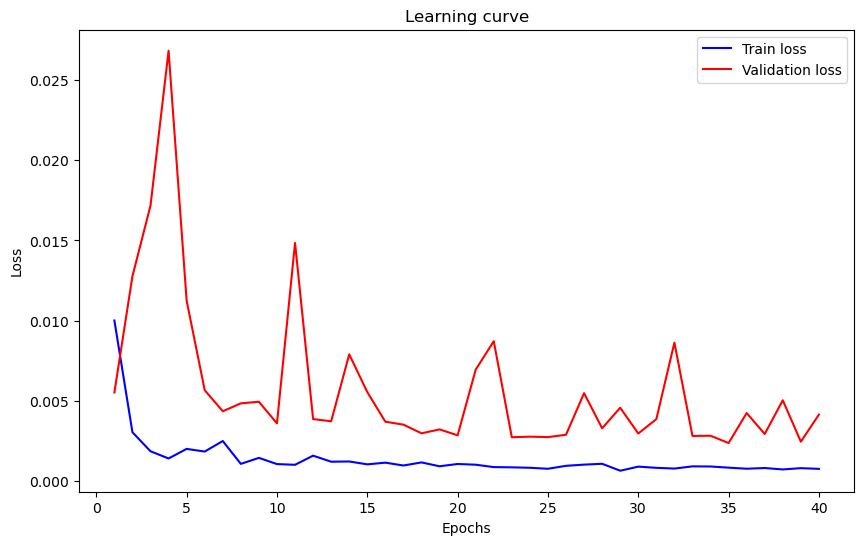

In [38]:
loss = accuracy.history['loss']
val_loss = accuracy.history['val_loss']

# Crear el gráfico de la curva de aprendizaje
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Learning curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('images/accuracy.png')
plt.show()